# 🏥 Notebook 4: AI Engineering

In this final notebook, we move beyond training into the **full lifecycle of an AI product**.  
This includes **deployment, monitoring, and maintenance**.  

---

## 🎯 Learning Objectives
By the end of this notebook, you will be able to:
1. Explain how to deploy an ML model using **FastAPI**.
2. Understand how to track experiments and monitor drift with **MLflow**.
3. Describe strategies for **automatic retraining**.
4. Reflect on challenges of AI in healthcare deployment.  

---


## 4.1 Deploying with FastAPI

Once trained, a model needs to be **accessible** to apps, clinicians, or hospital systems.  
We achieve this by wrapping the model in a web API.  

👉 **FastAPI** is a modern, Pythonic framework for building REST APIs.

⚠️ Note: Running FastAPI fully requires a server (not just Colab).  
Here, we’ll show the *concept* with code snippets.


💡 **How this works**:
- `/predict/` endpoint receives JSON patient features.
- FastAPI validates input → calls model → returns prediction.  

📌 To run locally:  
```bash
uvicorn app:app --reload
```

In [ ]:
#@title Install runtime libraries (if needed)
!pip -q install joblib scikit-learn fastapi uvicorn mlflow


In [ ]:
# app.py (replace your predict endpoint with this version)
import joblib
import pandas as pd
from fastapi import FastAPI
from pydantic import BaseModel

pipe = joblib.load("diabetes_model.pkl")

# Columns from Nb3 (Pima Indians Diabetes)
FEATURE_COLUMNS = [
    "pregnancies","glucose","blood_pressure","skin_thickness",
    "insulin","bmi","diabetes_pedigree","age"
]

class Patient(BaseModel):
    pregnancies: float
    glucose: float
    blood_pressure: float
    skin_thickness: float
    insulin: float
    bmi: float
    diabetes_pedigree: float
    age: float

app = FastAPI(title="Diabetes Risk API", version="1.0.0")

@app.post("/predict")
def predict(p: Patient):
    # Build a 1-row DataFrame with correct column names
    row = pd.DataFrame([p.model_dump()])[FEATURE_COLUMNS]
    yhat = int(pipe.predict(row)[0])

    proba = None
    try:
        proba = float(pipe.predict_proba(row)[0][1])
    except Exception:
        pass

    return {"prediction": yhat, "positive_probability": proba}


In [ ]:
from fastapi.testclient import TestClient
import app
client = TestClient(app.app)

sample = {
    "pregnancies": 2, "glucose": 120, "blood_pressure": 70,
    "skin_thickness": 20, "insulin": 85, "bmi": 26.0,
    "diabetes_pedigree": 0.5, "age": 35
}
client.post("/predict", json=sample).json()



### 🐳 Build & Run (Docker)
From this notebook's folder:

```bash
# Build
docker build -t diabetes-api:latest .

# Run
docker run --rm -p 8000:8000 diabetes-api:latest

# Test
curl -X POST http://localhost:8000/predict   -H "Content-Type: application/json"   -d '{
    "pregnancies": 2, "glucose": 120, "blood_pressure": 70,
    "skin_thickness": 20, "insulin": 85, "bmi": 26.0,
    "diabetes_pedigree": 0.5, "age": 35
  }'
```
Open `http://localhost:8000` (or `/docs`) to explore the API.


In [ ]:
#@title Write Dockerfile for shipping
%%writefile Dockerfile
# Minimal image to serve the trained pipeline with FastAPI
FROM python:3.11-slim
WORKDIR /app

# Pin runtime deps (match training!)
RUN pip install --no-cache-dir \
    fastapi==0.115.* \
    "uvicorn[standard]==0.30.*" \
    joblib==1.4.2 \
    numpy==1.26.* \
    pandas==2.2.* \
    scikit-learn==1.6.1   # <= match your training version

COPY app.py diabetes_model.pkl /app/
EXPOSE 7860

# IMPORTANT: bind to the port Spaces provides
CMD ["sh", "-c", "uvicorn app:app --host 0.0.0.0 --port ${PORT:-7860} --workers 1 --timeout-keep-alive 120"]



CMD Command

```
curl -X POST "https://karinhsw-diab-demo.hf.space/predict" -H "Content-Type: application/json" -d "{\"pregnancies\": 2, \"glucose\": 120, \"blood_pressure\": 70, \"skin_thickness\": 20, \"insulin\": 85, \"bmi\": 26.0, \"diabetes_pedigree\": 0.5, \"age\": 35}"
```

In [ ]:
import requests

BASE = "https://karinhsw-diab-demo.hf.space"
payload = {
    "pregnancies": 2, "glucose": 120, "blood_pressure": 70, "skin_thickness": 20,
    "insulin": 85, "bmi": 26.0, "diabetes_pedigree": 0.5, "age": 35
}
r = requests.post(f"{BASE}/predict", json=payload, timeout=60)
print(r.status_code, r.json())



### 📊 4.2 Model Monitoring with MLflow  


After deployment, we must **track performance** over time.  
- **Experiment tracking:** log hyperparams, metrics, artifacts  
- **Model registry:** manage versions (v1, v2…)  
- **Monitoring drift:** detect if performance declines on new patient data

In [ ]:
#@title MLflow Setup (local, file-based, with SQLite Model Registry)
!pip -q install mlflow==2.14.3 matplotlib scikit-learn pandas numpy

import os, mlflow
from mlflow import sklearn as mlflow_sklearn

# Use a local SQLite DB so we get a working Model Registry (names, versions)
os.environ["MLFLOW_TRACKING_URI"] = "sqlite:///mlflow.db"
mlflow.set_tracking_uri(os.environ["MLFLOW_TRACKING_URI"])

# Create/select experiment
EXPERIMENT_NAME = "PyHealth-Diabetes"
mlflow.set_experiment(EXPERIMENT_NAME)

print("Tracking URI:", mlflow.get_tracking_uri())
print("Experiment:", mlflow.get_experiment_by_name(EXPERIMENT_NAME))


In [ ]:
#@title Load Diabetes Data for Evaluation (same columns as Nb3)
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

data_url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = [
    "pregnancies","glucose","blood_pressure","skin_thickness",
    "insulin","bmi","diabetes_pedigree","age","outcome"
]
df = pd.read_csv(data_url, names=column_names)

X = df.drop(columns=["outcome"])
y = df["outcome"]


In [ ]:
#@title Log a Full Run (params, metrics, confusion matrix, model + signature)
import io, json, numpy as np, matplotlib.pyplot as plt
import mlflow
from mlflow.models.signature import infer_signature

# 'pipe' must be loaded already from diabetes_model.pkl in earlier cells
y_pred = pipe.predict(X)
try:
    y_proba = pipe.predict_proba(X)[:, 1]
    roc = roc_auc_score(y, y_proba)
except Exception:
    y_proba = None
    roc = None

acc = accuracy_score(y, y_pred)
cm = confusion_matrix(y, y_pred)

# Save confusion matrix as an artifact
fig = plt.figure(figsize=(4,3))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.tight_layout()
fig_path = "confusion_matrix.png"
fig.savefig(fig_path)
plt.close(fig)

# Infer model signature (schema) using a tiny sample row
sample = X.iloc[:5].copy()
signature = infer_signature(sample, pipe.predict(sample))

with mlflow.start_run(run_name="diabetes_pipeline_full"):
    # Params (capture core model choices if accessible)
    model_name = type(pipe.named_steps["model"]).__name__ if "model" in pipe.named_steps else type(pipe).__name__
    mlflow.log_param("model_type", model_name)
    mlflow.log_param("n_features", X.shape[1])
    mlflow.log_param("dataset", "Pima Indians Diabetes")

    # Metrics
    mlflow.log_metric("accuracy", float(acc))
    if roc is not None:
        mlflow.log_metric("roc_auc", float(roc))

    # Artifacts
    mlflow.log_artifact(fig_path)

    # Log input example for better serving docs
    input_example = sample.to_dict(orient="records")[0]

    # Log the pipeline as an MLflow model
    mlflow.sklearn.log_model(
        sk_model=pipe,
        artifact_path="diabetes_pipeline",
        signature=signature,
        input_example=input_example
    )

    run = mlflow.active_run()
    run_id = run.info.run_id
    print("✅ Logged run:", run_id)


In [ ]:
#@title Register the Model and Load by Name:Version
import mlflow
from mlflow.tracking import MlflowClient

client = MlflowClient()
model_registry_name = "DiabetesPipeline"

# Find the last logged model artifact path from the previous run
runs = mlflow.search_runs(order_by=["start_time DESC"], max_results=1)
assert len(runs) == 1
last_run_id = runs.iloc[0]["run_id"]
model_uri = f"runs:/{last_run_id}/diabetes_pipeline"

# Register!
registered = mlflow.register_model(model_uri=model_uri, name=model_registry_name)
print("📦 Registered:", registered.name, "version:", registered.version)

# (Optional) Transition stage
client.transition_model_version_stage(
    name=model_registry_name, version=registered.version, stage="Staging", archive_existing_versions=False
)
print("🔖 Transitioned to:", "Staging")

# Load by name:stage (or name:version)
loaded = mlflow.pyfunc.load_model(model_uri=f"models:/{model_registry_name}/Staging")
print("✅ Loaded by name:stage; type:", type(loaded))

# Sanity check prediction with the MLflow-wrapped model
pred = loaded.predict(X.iloc[:3])
print("Pred sample:", pred.tolist())


In [ ]:
#@title Compare Runs
import mlflow, pandas as pd
runs = mlflow.search_runs(experiment_names=[EXPERIMENT_NAME], order_by=["start_time DESC"])
display(runs[["run_id","status","metrics.accuracy","metrics.roc_auc","params.model_type","start_time"]].head(10))


In [ ]:
#@title Browse Artifacts & Load the Latest Model
import os, mlflow, glob, json, pandas as pd

exp = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
print("Experiment ID:", exp.experiment_id)

# Show the last run’s artifact tree
runs = mlflow.search_runs(experiment_names=[EXPERIMENT_NAME], order_by=["start_time DESC"], max_results=1)
rid = runs.iloc[0]["run_id"]
print("Last run id:", rid)

art_dir = f"mlruns/{exp.experiment_id}/{rid}/artifacts"
for root, dirs, files in os.walk(art_dir):
    level = root.replace(art_dir, "").count(os.sep)
    indent = "  " * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = "  " * (level + 1)
    for f in files:
        print(f"{subindent}{f}")

# Load the logged sklearn model (as sklearn flavor)
model = mlflow.sklearn.load_model(f"runs:/{rid}/diabetes_pipeline")
print("Reloaded model:", type(model))
print("Predict head:", model.predict(X.iloc[:5]).tolist())


## 4.3 Automatic Retraining

Models can degrade over time (called **drift**) due to:
- Changing patient populations
- New hospital equipment
- Data recording practices

**Solution:** retrain periodically or when metrics drop below a threshold.  

⚠️ In production, this would be done with:
- ML pipelines (Airflow, Kubeflow)
- Continuous retraining jobs
- Human-in-the-loop for validation


In [ ]:
#@title Degrade tabular data across runs and log to MLflow
# Requires: pipe (loaded from diabetes_model.pkl), X, y defined (Pima Indians Diabetes)
!pip -q install mlflow==2.14.3 matplotlib

import numpy as np, pandas as pd, mlflow, os, math, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from copy import deepcopy

# ---- MLflow setup (local file-based) ----
os.environ["MLFLOW_TRACKING_URI"] = "sqlite:///mlflow.db"
mlflow.set_tracking_uri(os.environ["MLFLOW_TRACKING_URI"])
EXPERIMENT_NAME = "PyHealth-Drift-Demo"
mlflow.set_experiment(EXPERIMENT_NAME)

rng_global = np.random.default_rng(42)

# ---- Degradation functions (choose one or combine) ----
def covariate_shift(df: pd.DataFrame, severity: float, rng: np.random.Generator):
    """Shift feature distributions (mean + noise). Larger severity => larger mean shift & noise."""
    df2 = df.copy()
    # emphasize clinically-relevant features in Pima dataset
    shifts = {
        "glucose": 10.0 * severity,       # add mean shift
        "bmi": 1.0 * severity,
        "blood_pressure": 2.0 * severity
    }
    for col, mu in shifts.items():
        if col in df2:
            df2[col] = df2[col] + mu + rng.normal(0, 0.5 * severity, size=len(df2))
    return df2

def feature_dropout(df: pd.DataFrame, severity: float, rng: np.random.Generator):
    """Randomly introduce missingness with dtype safety (cast to float before NaNs)."""
    df2 = df.copy()

    # Cast all numeric columns to float so NaN is representable
    num_cols = df2.select_dtypes(include=["number"]).columns.tolist()
    df2[num_cols] = df2[num_cols].astype("float64")

    p_missing = min(0.6, 0.08 * severity)  # up to 48% at severity=6
    cols = [c for c in df2.columns if c != "outcome"]
    mask = rng.random((len(df2), len(cols))) < p_missing

    # Apply mask
    df2.loc[:, cols] = df2.loc[:, cols].mask(mask)
    return df2


def label_noise(y: pd.Series, severity: float, rng: np.random.Generator):
    """Flip a fraction of labels to simulate annotation noise / coding errors."""
    y2 = y.copy()
    p_flip = min(0.35, 0.05 * severity)
    idx = rng.choice(len(y2), size=int(p_flip * len(y2)), replace=False)
    y2.iloc[idx] = 1 - y2.iloc[idx]
    return y2

def class_prior_shift(X: pd.DataFrame, y: pd.Series, severity: float, rng: np.random.Generator):
    """Undersample the minority/majority class to change class balance."""
    X2, y2 = X.copy(), y.copy()
    target_pos_rate = np.clip(y2.mean() - 0.05 * severity, 0.05, 0.5)  # push pos-rate down
    pos_idx = np.flatnonzero(y2.values == 1)
    neg_idx = np.flatnonzero(y2.values == 0)
    rng.shuffle(pos_idx); rng.shuffle(neg_idx)
    # sample to achieve target rate
    n_total = len(y2)
    n_pos = int(target_pos_rate * n_total)
    n_neg = n_total - n_pos
    keep_idx = np.concatenate([pos_idx[:n_pos], neg_idx[:n_neg]])
    keep_idx.sort()
    return X2.iloc[keep_idx].reset_index(drop=True), y2.iloc[keep_idx].reset_index(drop=True)

def nonlinear_domain_shift(df: pd.DataFrame, severity: float, rng: np.random.Generator):
    """Apply mild nonlinear transforms (scale/warp) to a couple of features."""
    df2 = df.copy()
    s = 0.05 * severity
    if "glucose" in df2:
        df2["glucose"] = df2["glucose"] * (1 + s) + s * (df2["glucose"] ** 0.5)
    if "bmi" in df2:
        df2["bmi"] = df2["bmi"] * (1 + 0.5 * s) + rng.normal(0, 0.3 * severity, size=len(df2))
    return df2

# ---- Utility: evaluate and log one run ----
def evaluate_and_log(pipe, X_eval, y_eval, scheme_name, severity, extra_tags=None):
    import pandas as pd, numpy as np, math, mlflow, matplotlib.pyplot as plt
    from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

    # Rebuild DataFrame with original columns and float dtype (avoids future dtype issues)
    X_eval = pd.DataFrame(X_eval, columns=X.columns).astype("float64")

    y_pred = pipe.predict(X_eval)
    acc = accuracy_score(y_eval, y_pred)
    try:
        y_proba = pipe.predict_proba(X_eval)[:, 1]
        roc = roc_auc_score(y_eval, y_proba)
    except Exception:
        y_proba, roc = None, None

        # Log params/metrics
        mlflow.log_param("scheme", scheme_name)
        mlflow.log_param("severity", severity)
        mlflow.log_metric("accuracy", float(acc))
        if roc is not None and not math.isnan(roc):
            mlflow.log_metric("roc_auc", float(roc))

        # Confusion matrix as artifact
        cm = confusion_matrix(y_eval, y_pred)
        fig = plt.figure(figsize=(4,3))
        plt.imshow(cm, interpolation="nearest")
        plt.title(f"CM - {scheme_name} s={severity}")
        plt.xlabel("Pred"); plt.ylabel("True")
        for (i,j), v in np.ndenumerate(cm):
            plt.text(j, i, str(v), ha="center", va="center")
        plt.tight_layout()
        fig_path = f"cm_{scheme_name}_{severity}.png"
        fig.savefig(fig_path); plt.close(fig)
        mlflow.log_artifact(fig_path)

        # Tag model type
        try:
            mdl = pipe.named_steps.get("model", pipe)
            mlflow.set_tag("model_type", type(mdl).__name__)
        except Exception:
            pass

        if extra_tags:
            for k,v in extra_tags.items():
                mlflow.set_tag(k, v)

        print(f"Logged: scheme={scheme_name}, severity={severity}, acc={acc:.3f}, roc={roc if roc is None else round(roc,3)}")

# ---- Runner: generate degraded datasets and log multiple runs ----
def run_degradation_experiment(pipe, X, y, schemes=("covariate_shift","feature_dropout","label_noise","class_prior_shift","nonlinear_domain_shift"),
                               severities=(0,1,2,3,4,5), base_seed=13):
    for scheme in schemes:
        for sev in severities:
            rng = np.random.default_rng(base_seed + sev*101)
            Xd, yd = X.copy(), y.copy()

            if scheme == "covariate_shift":
                Xd = covariate_shift(Xd, sev, rng)
            elif scheme == "feature_dropout":
                Xd = feature_dropout(Xd, sev, rng)
            elif scheme == "label_noise":
                yd = label_noise(yd, sev, rng)
            elif scheme == "class_prior_shift":
                Xd, yd = class_prior_shift(Xd, yd, sev, rng)
            elif scheme == "nonlinear_domain_shift":
                Xd = nonlinear_domain_shift(Xd, sev, rng)
            else:
                raise ValueError("Unknown scheme: " + scheme)

            evaluate_and_log(pipe, Xd, yd, scheme_name=scheme, severity=sev)

# ---- Execute the demo ----
# Assumes X,y from Pima dataset, and 'pipe' fitted in Nb3 and loaded here.
run_degradation_experiment(pipe, X, y)

print("✅ Degradation runs logged. Use mlflow.search_runs(...) to compare.")


In [ ]:
# Show recent runs in a nice DataFrame
import mlflow, pandas as pd

runs = mlflow.search_runs(
    experiment_names=["PyHealth-Drift-Demo"],
    order_by=["start_time DESC"]
)
display(runs[[
    "run_id", "params.scheme", "params.severity",
    "metrics.accuracy", "metrics.roc_auc", "start_time"
]])


In [ ]:
import matplotlib.pyplot as plt

df = runs.copy()
df["severity"] = df["params.severity"].astype(float)

plt.figure(figsize=(8,5))
for scheme, g in df.groupby("params.scheme"):
    plt.plot(g["severity"], g["metrics.accuracy"], marker="o", label=f"{scheme} (acc)")
plt.axhline(0.75, color="red", linestyle="--", label="Threshold")
plt.title("Accuracy vs. Severity")
plt.xlabel("Severity")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
for scheme, g in df.groupby("params.scheme"):
    if g["metrics.roc_auc"].notna().any():
        plt.plot(g["severity"], g["metrics.roc_auc"], marker="s", label=f"{scheme} (ROC AUC)")
plt.axhline(0.80, color="red", linestyle="--", label="Threshold")
plt.title("ROC AUC vs. Severity")
plt.xlabel("Severity")
plt.ylabel("ROC AUC")
plt.legend()
plt.show()

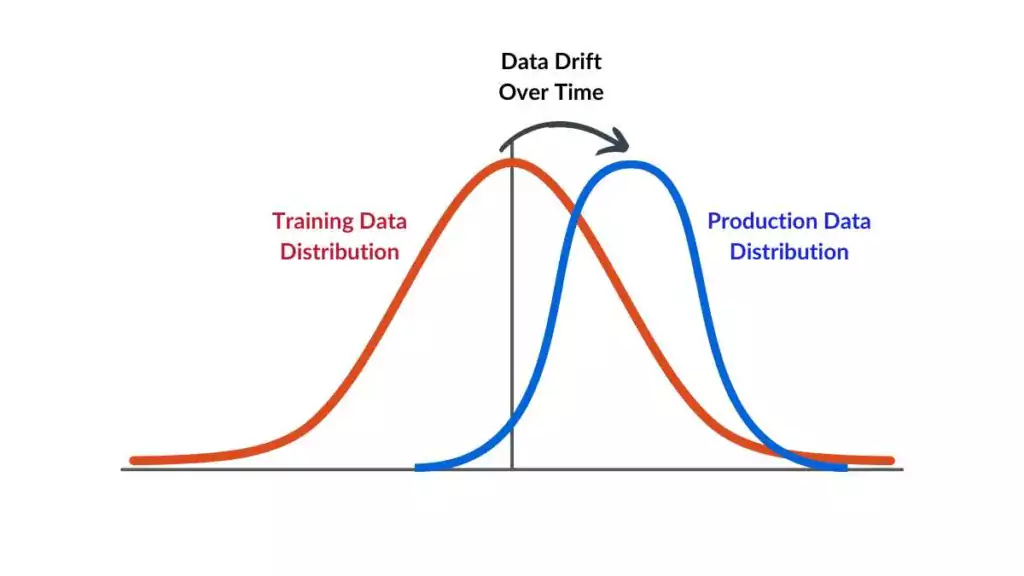

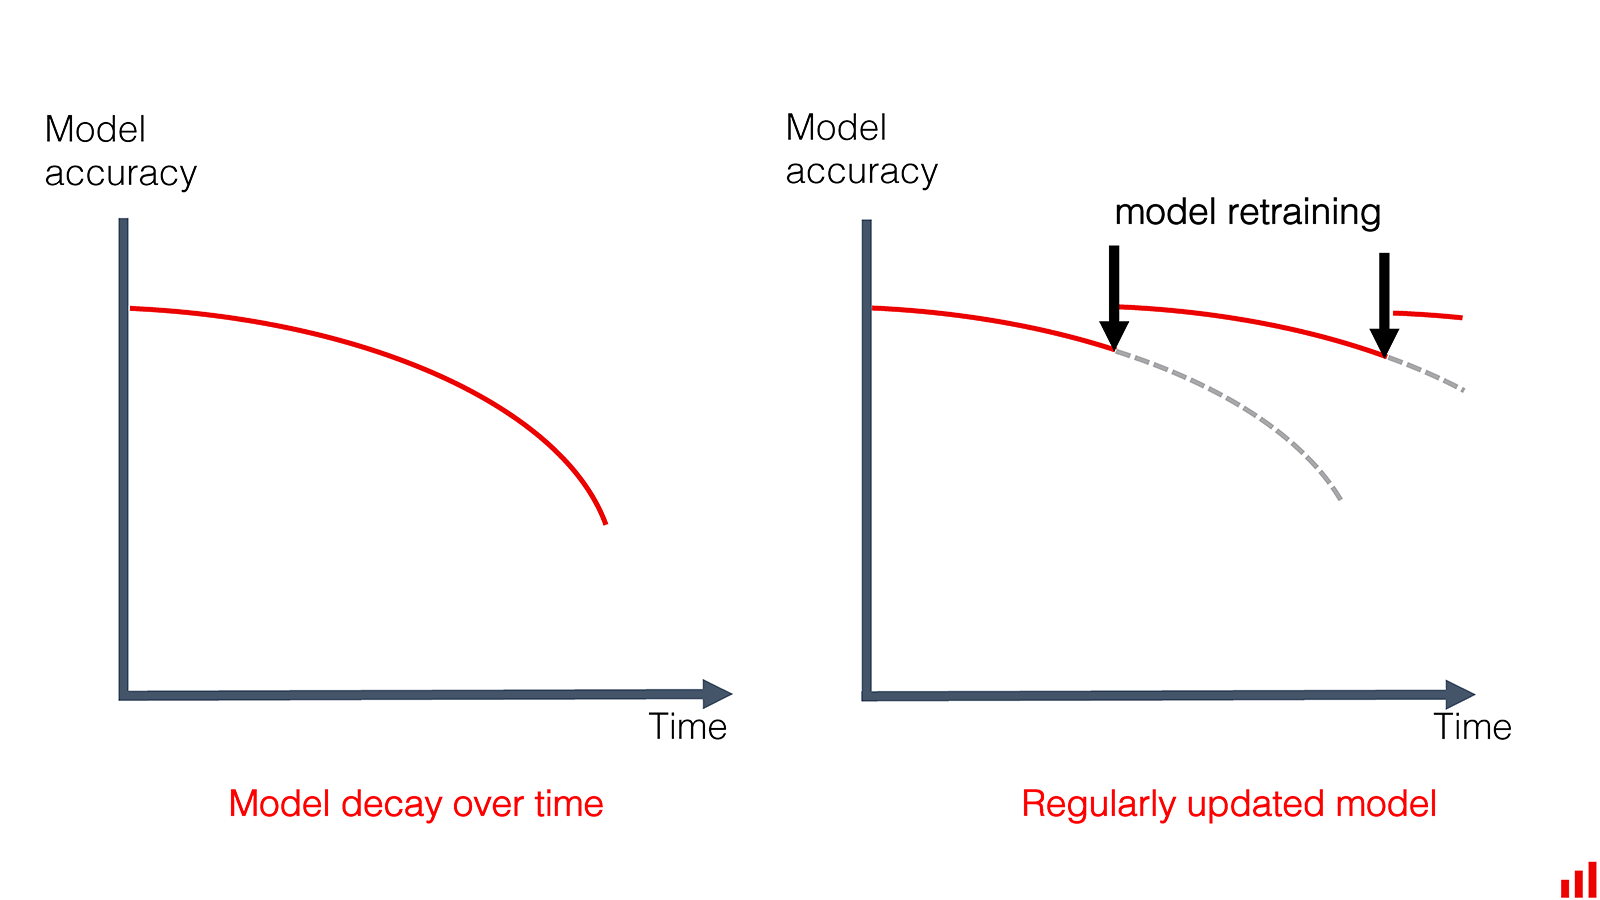

# ✅ Summary

In this notebook, you learned:
- How to wrap a model in a FastAPI service.
- How to log experiments & metrics with MLflow.
- Why automatic retraining is critical.

---

## 🌍 Reflection
1. What risks arise if a deployed healthcare model drifts unnoticed?  
2. Who should approve retrained models before deployment?  
3. How would you design a **safe retraining policy** in a hospital?  

---

🎉 Congratulations! You’ve completed the course:
- **Notebook 1:** Setup & Python Basics  
- **Notebook 2:** ML for Pneumonia Detection  
- **Notebook 3:** ML with Tabular Data  
- **Notebook 4:** AI Engineering & Deployment  

👉 Next steps: Build your **own healthcare AI project**, from data → model → deployment.
